<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

In [1]:
import os
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

c:\ProgramData\anaconda3\envs\LLM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\ProgramData\anaconda3\envs\LLM\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
import transformers
from datasets import load_dataset
import evaluate

c:\ProgramData\anaconda3\envs\LLM\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertModel

In [4]:
from torch.utils.data import Dataset, DataLoader
from transformers import DataCollatorWithPadding, DataCollatorWithPadding, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [5]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
device

'cuda'

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [6]:
### This is just an interface example. You may change it if you want.

# Быстрый класс для тюнинга (без attention карт)
class TrainerClassificationModel(nn.Module):
    def __init__(self, bert_model_name: str, device, cnt_class=4):
        # YOUR CODE: create additional layers for classfication
        # self.backbone = #...
        super().__init__()
        self.device = device
        self.cnt_class = cnt_class
        self.tokenizer = AutoTokenizer.from_pretrained(bert_model_name, use_fast=True)
        self.model = AutoModelForSequenceClassification.from_pretrained(bert_model_name, 
                                                                        attn_implementation="sdpa", 
                                                                        num_labels=self.cnt_class)
                                                                        # .to(self.device)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, **batch):
        # YOUR CODE: propagate inputs through the model. Return dict with logits
        # batch.pop("num_items_in_batch", None)
        out = self.model(**batch)  # SequenceClassifierOutput
        return out
        
    # def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
    #     return self.model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)

# Медленный класс для анализа (с attention картами)
class AttentionModel(nn.Module):
    def __init__(self, model_name: str, device, cnt_class=4):
        super().__init__()
        self.device = device
        self.cnt_class = cnt_class
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=self.cnt_class,
            attn_implementation="eager",    
        )
        self.model.eval()

        self.model.config.return_dict = True
        self.model.config.output_attentions = True
        # self.model.config.output_hidden_states = False
        self.last_attentions = None        

    def forward(self, **batch):
        out = self.model(**batch)
        self.last_attentions = out.attentions  # tuple[layer] -> (batch, heads, seq_l, seq_l)
        # return out.attentions
        return {"logits": out.logits, "attentions": out.attentions}

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [7]:
def freeze_backbone_function(model: TrainerClassificationModel):
    # Заморозим все слои, кроме классификатора
    for w in model.model.bert.parameters():
        w.requires_grad = False
    for w in model.model.classifier.parameters():
        w.requires_grad = True

    return model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

Вначале надо создать класс датасет и даталоадер для обоих файлов

In [8]:
rudata = pd.read_excel('data_problems.xlsx', usecols=[1,2])
endata = pd.read_excel('data_problems_translated.xlsx', usecols=[1,2])

In [9]:
codes, uniques = pd.factorize(rudata['Тема'], sort=True)  # sort=False — по порядку появления
rudata['class_id'] = codes
# Словарь соответствий:
ru_mapping = {cat: i for i, cat in enumerate(uniques)}

codes, uniques = pd.factorize(endata['topic'], sort=True)  # sort=False — по порядку появления
endata['class_id'] = codes
# Словарь соответствий:
en_mapping = {cat: i for i, cat in enumerate(uniques)}

In [10]:
# Часть значений в endata были пустые
bad = []
for i, t in enumerate(endata['problem_text'].tolist()):
    ok = isinstance(t, str)
    if not ok:
        bad.append((i, type(t).__name__, t))
bad

[(1892, 'float', nan),
 (2052, 'float', nan),
 (2724, 'float', nan),
 (3473, 'float', nan),
 (4072, 'float', nan)]

In [11]:
endata.drop(index=[item[0] for item in bad], inplace=True)

In [12]:
X = rudata['Задача']
y = rudata['class_id']
ru_X_train, ru_X_test, ru_y_train, ru_y_test = train_test_split(X, y, test_size=0.1, random_state=42)  

X = endata['problem_text']
y = endata['class_id']
en_X_train, en_X_test, en_y_train, en_y_test = train_test_split(X, y, test_size=0.1, random_state=42)  

In [13]:
MODEL_NAME = 'cointegrated/rubert-tiny2'
rubert_tiny_transformer_model = TrainerClassificationModel(MODEL_NAME, device, len(ru_mapping))

MODEL_NAME = 'tbs17/MathBert'
mathbert_tiny_transformer_model = TrainerClassificationModel(MODEL_NAME, device, len(en_mapping))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tbs17/MathBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
ru_tokenizer = rubert_tiny_transformer_model.tokenizer
en_tokenizer = mathbert_tiny_transformer_model.tokenizer

class TextClassificationDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_length=1024):
        self.X = X.tolist()  
        self.y = y.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        text = self.X[idx]
        label = int(self.y[idx])
        enc = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
        )
        enc["labels"] = label
        return enc
    
    # def text_to_tokens_ids(self, text):
    #     tokens = self.tokenizer.tokenize(text)
    #     return torch.tensor(self.tokenizer.convert_tokens_to_ids(tokens)).to(device)

# max_len = int(rubert_tiny_transformer_model.model.config.max_position_embeddings) # 2048 
max_len = 1024
ru_train_ds = TextClassificationDataset(ru_X_train, ru_y_train, ru_tokenizer, max_length=max_len)
ru_test_ds = TextClassificationDataset(ru_X_test, ru_y_test, ru_tokenizer, max_length=max_len)

max_len = int(mathbert_tiny_transformer_model.model.config.max_position_embeddings) 
en_train_ds = TextClassificationDataset(en_X_train, en_y_train, en_tokenizer, max_length=max_len) # 512 
en_test_ds = TextClassificationDataset(en_X_test, en_y_test, en_tokenizer, max_length=max_len)

## Если хотим обучать через готовый трейнер

In [ ]:
# # Метрики (accuracy + macro-F1)
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     preds = np.argmax(logits, axis=-1)
#     return {
#         "accuracy": accuracy_score(labels, preds),
#         "f1_macro": f1_score(labels, preds, average="macro"),
#     }

In [ ]:
# def train_transformer(model, train_ds, test_ds, freeze_backbone=True):
#     if freeze_backbone:
#         model = freeze_backbone_function(model)

#     # Динамический паддинг
#     data_collator = DataCollatorWithPadding(tokenizer=ru_tokenizer, return_tensors="pt")

#     training_args = TrainingArguments(

#         output_dir="./results",
#         logging_dir="./logs",

#         learning_rate=2e-5,
#         per_device_train_batch_size=16,
#         per_device_eval_batch_size=16,
#         weight_decay=0.01,
#         num_train_epochs=10,
#         save_total_limit=3,

#         eval_strategy="steps",
#         eval_steps=50,
#         save_strategy="steps",
#         save_steps=50,           
#         load_best_model_at_end=True,
#         metric_for_best_model="accuracy",
#         greater_is_better=True,
#         logging_steps=50,           # как часто логировать train loss/lr
#         logging_strategy="steps",   # или "epoch"
#         # report_to=["tensorboard"],  # включить TB
#     )

#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_ds,
#         eval_dataset=test_ds,
#         processing_class=ru_tokenizer,
#         data_collator=data_collator,
#         compute_metrics=compute_metrics
#     )
    
#     # Не передавать loss-kwargs (в т.ч. num_items_in_batch) в model.forward
#     trainer.model_accepts_loss_kwargs = False

#     trainer.label_names = ["labels"]

#     trainer.train()
#     best_model = trainer.model       

#     return best_model


# rubert_tiny_finetuned_with_freezed_backbone = train_transformer(rubert_tiny_transformer_model, ru_train_ds, ru_test_ds, freeze_backbone=True)

In [ ]:
# from sklearn.metrics import classification_report
# from tqdm.auto import tqdm

# # # получить предсказания и лейблы
# # preds_output = trainer.predict(test_ds)

# # # logits → классы
# # preds = np.argmax(preds_output.predictions, axis=-1)
# # labels = preds_output.label_ids

# rubert_tiny_finetuned_with_freezed_backbone.eval()
# all_preds, all_labels = [], []
# device = next(rubert_tiny_finetuned_with_freezed_backbone.parameters()).device

# for batch in tqdm(test_loader):
#     batch = {k: v.to(device) for k, v in batch.items()}
#     with torch.no_grad():
#         outputs = rubert_tiny_finetuned_with_freezed_backbone(**batch)
#         preds = outputs.logits.argmax(dim=-1).cpu().numpy()
#         labels = batch["labels"].cpu().numpy()
#         all_preds.extend(preds)
#         all_labels.extend(labels)


# print(classification_report(all_labels, all_preds, target_names=mapping.keys()))

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

## Если хотим кастомно обучать без трейнера хагинг фейс

In [37]:
ru_collate_fn = DataCollatorWithPadding(tokenizer=ru_tokenizer, return_tensors="pt")
en_collate_fn = DataCollatorWithPadding(tokenizer=en_tokenizer, return_tensors="pt")

BATCH_SIZE = 32

ru_train_loader = DataLoader(
    ru_train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=ru_collate_fn,
    num_workers=0,
    pin_memory=True
)

ru_test_loader = DataLoader(
    ru_test_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=ru_collate_fn,
    num_workers=0,
    pin_memory=True
)

en_train_loader = DataLoader(
    en_train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=en_collate_fn,
    num_workers=0,
    pin_memory=True
)

en_test_loader = DataLoader(
    en_test_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=en_collate_fn,
    num_workers=0,
    pin_memory=True
)

In [38]:
LR = 1e-4
NUM_EPOCHS = 20
torch.manual_seed(42); np.random.seed(42); 
# random.seed(42)

In [39]:
import gc
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
def clear_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        torch.cuda.empty_cache()

    gc.collect()

In [40]:
print(f"Memory allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

Memory allocated: 1.85 GB


In [41]:
from transformers import get_linear_schedule_with_warmup

In [42]:
def train_model(model, num_epoch, train_loader, test_loader, model_name, freeze_backbone=True):
    
    if freeze_backbone:
        model = freeze_backbone_function(model)

    # sanity-check:
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total     = sum(p.numel() for p in model.parameters())
    print(f"trainable params: {trainable} / {total}")

    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.AdamW((p for p in model.parameters() if p.requires_grad), lr=LR)

    num_batches_per_epoch = len(train_loader)  
    num_training_steps = num_epoch * num_batches_per_epoch  
    num_warmup_steps = int(0.1 * num_training_steps) 

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,       
        num_training_steps=num_training_steps,   
)

    # lambda_scheduler = lambda x: SCHEDULER_LAMBDA_PARAM ** x
    # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_scheduler)

    best_loss = float('inf') 
    best_model_wts = None
    best_y_true, best_y_pred = None, None
    history = dict(train_loss=[], val_loss=[], val_acc=[], val_f1_macro=[])

    for epoch in range(num_epoch):
        clear_gpu_memory()
        print(f'epoch {epoch+1} // {num_epoch}')
        # ---------- TRAIN ----------
        model.train()
        running_loss = 0.0

        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            batch = {k: v.to(device) for k, v in batch.items()}
            # model.to(device)
            outputs = model(**batch)
            loss = criterion(outputs.logits, batch['labels'])
            # loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        history['train_loss'].append(train_loss)
        print(f'train_loss = {train_loss}')
        # ---------- EVAL ----------
        model.eval()
        val_running = 0.0
        y_true, y_pred = [], []

        with torch.no_grad():
            for batch in test_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = criterion(outputs.logits, batch['labels'])
                val_running += loss.item()

                preds = outputs.logits.argmax(dim=-1)
                y_pred.append(preds.cpu().numpy())
                y_true.append(batch['labels'].cpu().numpy())

            val_loss = val_running / len(test_loader)
            print(f'val_loss = {val_loss}')
                    
            y_true = np.concatenate(y_true)
            y_pred = np.concatenate(y_pred)

            val_acc = accuracy_score(y_true, y_pred)
            f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
            # f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            history['val_f1_macro'].append(f1_macro)
            # history['val_f1_weighted'].append(f1_weighted)

            # save best by val_loss
            if val_loss < best_loss:
                best_loss = val_loss
                best_model_wts = model.state_dict()

                model_path = os.path.join('models', f"{model_name}.pth")
                torch.save(best_model_wts, model_path)

                best_y_true, best_y_pred = y_true, y_pred

    return history, model, best_y_true, best_y_pred

In [43]:
def get_losses_plot(history, num_epoch):
    ax = plt.figure().gca()
    ax.plot(history['train_loss'], color='g')
    ax.plot(history['val_loss'], color='r')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend([
    'train', 
    'val'
                ])
    ax.set_xticklabels([i for i in range(num_epoch)])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    return ax

def get_metrics_plot(history, num_epoch):
    fig = plt.figure(figsize=(16, 4))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.plot(history['val_acc'], color='g')
    ax2.plot(history['val_f1_macro'], color='r')
    ax1.set_ylabel('Metrics')
    ax2.set_ylabel('Metrics')
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')
    ax1.set_xticklabels([i for i in range(NUM_EPOCHS)])
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.set_xticklabels([i for i in range(NUM_EPOCHS)])
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax1.grid()
    ax2.grid()
    ax1.legend(['val_acc'])
    ax2.legend(['val_f1_macro'])
    return fig.show()

## rubert_tiny_transformer_model

In [ ]:
rubert_tiny_transformer_model = rubert_tiny_transformer_model.to(device)
history, model, y_true, y_pred = train_model(
    rubert_tiny_transformer_model,
    NUM_EPOCHS,
    ru_train_loader,
    ru_test_loader,
    'ru_freeze',
    freeze_backbone=True,
)

trainable params: 2191 / 29195959


100%|██████████| 38/38 [00:09<00:00,  4.16it/s]


C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_24292\3782166417.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([i for i in range(num_epoch)])
C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_24292\3782166417.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  return fig.show()


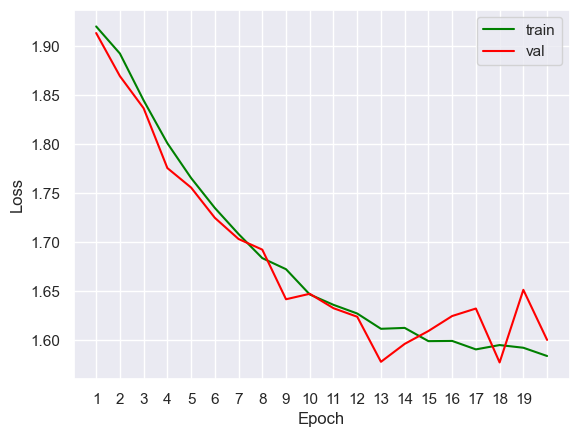

In [ ]:
get_losses_plot(history, NUM_EPOCHS)

C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_24292\3412083764.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([i for i in range(NUM_EPOCHS)])
C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_24292\3412083764.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([i for i in range(NUM_EPOCHS)])
C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_24292\3412083764.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  return fig.show()


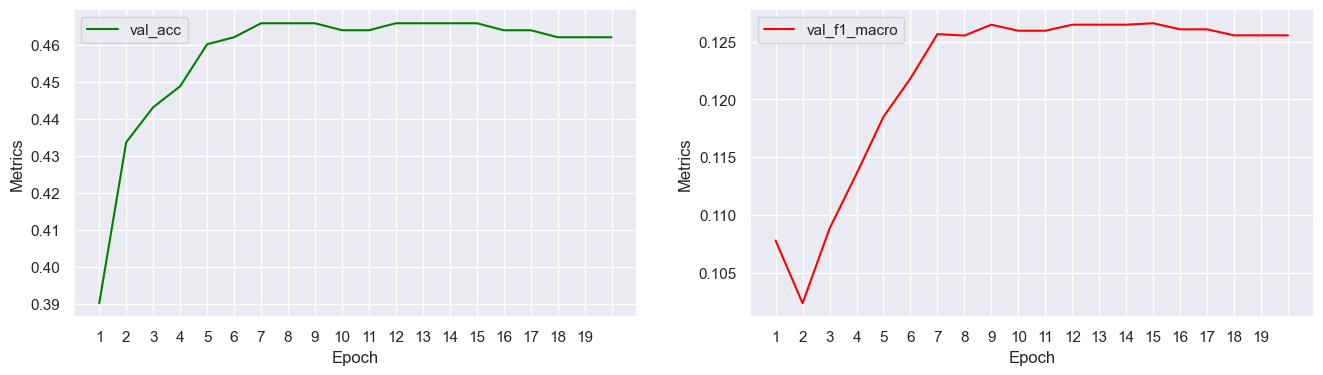

In [62]:
get_metrics_plot(history, NUM_EPOCHS)

In [ ]:
print(classification_report(y_true, y_pred, digits=4, zero_division=0))
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        43
           1     0.0000    0.0000    0.0000        39
           2     0.0000    0.0000    0.0000        50
           3     0.0000    0.0000    0.0000        23
           4     0.3469    0.1868    0.2429        91
           5     0.0000    0.0000    0.0000        45
           6     0.4759    0.9578    0.6359       237

    accuracy                         0.4621       528
   macro avg     0.1175    0.1635    0.1255       528
weighted avg     0.2734    0.4621    0.3273       528



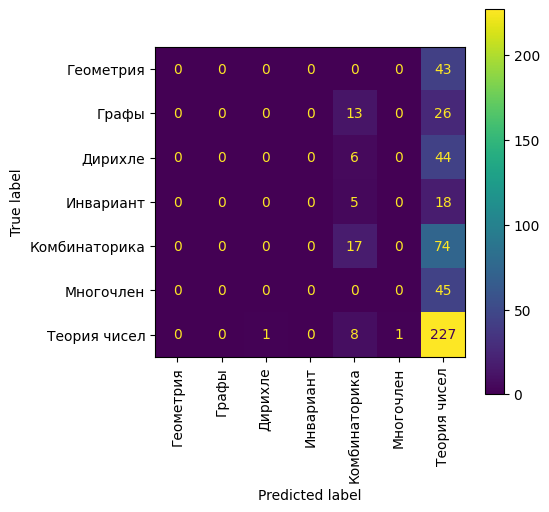

In [ ]:
plt.rcParams["figure.figsize"] = (5,5) 
disp = ConfusionMatrixDisplay(cm, display_labels = ru_mapping.keys())
disp.plot(xticks_rotation='vertical')

In [ ]:
MODEL_NAME = 'cointegrated/rubert-tiny2'
rubert_tiny_transformer_model = TrainerClassificationModel(MODEL_NAME, device, len(ru_mapping)).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
history, model, y_true, y_pred = train_model(
    rubert_tiny_transformer_model,
    NUM_EPOCHS,
    ru_train_loader,
    ru_test_loader,
    'ru_full',
    freeze_backbone=False,
)

trainable params: 29195959 / 29195959
epoch 0 // 20


100%|██████████| 75/75 [00:15<00:00,  4.89it/s]


epoch 1 // 20


100%|██████████| 75/75 [00:16<00:00,  4.50it/s]


epoch 2 // 20


100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


epoch 3 // 20


100%|██████████| 75/75 [00:16<00:00,  4.48it/s]


epoch 4 // 20


100%|██████████| 75/75 [00:16<00:00,  4.61it/s]


epoch 5 // 20


100%|██████████| 75/75 [00:17<00:00,  4.26it/s]


epoch 6 // 20


100%|██████████| 75/75 [00:18<00:00,  4.14it/s]


epoch 7 // 20


100%|██████████| 75/75 [00:17<00:00,  4.28it/s]


epoch 8 // 20


100%|██████████| 75/75 [00:16<00:00,  4.54it/s]


epoch 9 // 20


100%|██████████| 75/75 [00:18<00:00,  4.16it/s]


epoch 10 // 20


100%|██████████| 75/75 [00:15<00:00,  4.95it/s]


epoch 11 // 20


100%|██████████| 75/75 [00:17<00:00,  4.24it/s]


epoch 12 // 20


100%|██████████| 75/75 [00:19<00:00,  3.89it/s]


epoch 13 // 20


100%|██████████| 75/75 [00:16<00:00,  4.62it/s]


epoch 14 // 20


100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


epoch 15 // 20


100%|██████████| 75/75 [00:16<00:00,  4.46it/s]


epoch 16 // 20


100%|██████████| 75/75 [00:19<00:00,  3.91it/s]


epoch 17 // 20


100%|██████████| 75/75 [00:16<00:00,  4.55it/s]


epoch 18 // 20


100%|██████████| 75/75 [00:16<00:00,  4.66it/s]


epoch 19 // 20


100%|██████████| 75/75 [00:17<00:00,  4.34it/s]


C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_21796\1291969155.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([i for i in range(num_epoch)])


<Axes: xlabel='Epoch', ylabel='Loss'>

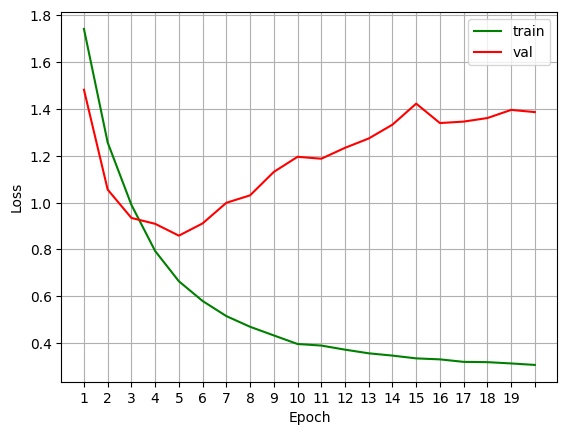

In [39]:
get_losses_plot(history, NUM_EPOCHS)

C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_21796\3979432584.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([i for i in range(NUM_EPOCHS)])
C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_21796\3979432584.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([i for i in range(NUM_EPOCHS)])
C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_21796\3979432584.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  return fig.show()


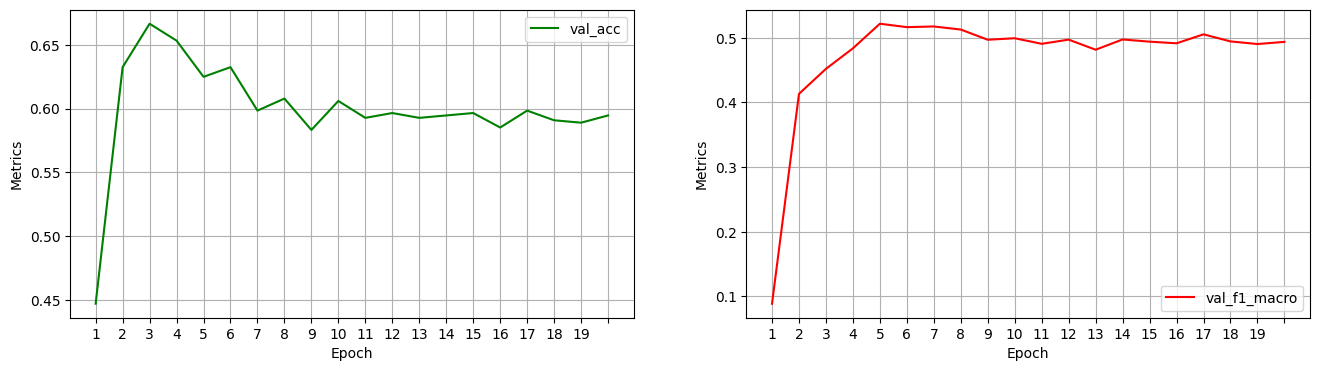

In [42]:
get_metrics_plot(history, NUM_EPOCHS)

In [54]:
print(classification_report(y_true, y_pred, digits=4, zero_division=0))
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

           0     0.9762    0.9535    0.9647        43
           1     0.0000    0.0000    0.0000        39
           2     0.4000    0.3600    0.3789        50
           3     0.4615    0.2609    0.3333        23
           4     0.3615    0.5165    0.4253        91
           5     0.7308    0.8444    0.7835        45
           6     0.7725    0.7595    0.7660       237

    accuracy                         0.6250       528
   macro avg     0.5289    0.5278    0.5217       528
weighted avg     0.6088    0.6250    0.6129       528



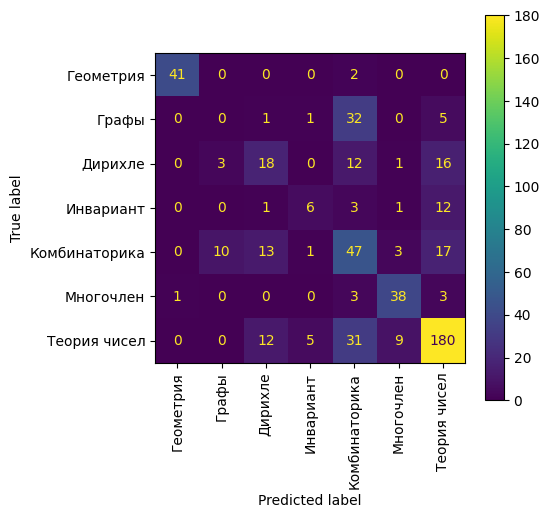

In [92]:
plt.rcParams["figure.figsize"] = (5,5) 
disp = ConfusionMatrixDisplay(cm, display_labels = ru_mapping.keys())
disp.plot(xticks_rotation='vertical')

## Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [44]:
MODEL_NAME = 'tbs17/MathBert'
mathbert_tiny_transformer_model = TrainerClassificationModel(MODEL_NAME, device, len(en_mapping)).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tbs17/MathBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
history, model, y_true, y_pred = train_model(
    mathbert_tiny_transformer_model,
    NUM_EPOCHS,
    en_train_loader,
    en_test_loader,
    'en_freeze',
    freeze_backbone=True,
)

trainable params: 5383 / 109487623
epoch 1 // 20


100%|██████████| 149/149 [00:21<00:00,  7.09it/s]


train_loss = 1.9149997418358822
val_loss = 1.661326478509342
epoch 2 // 20


100%|██████████| 149/149 [00:19<00:00,  7.46it/s]


train_loss = 1.6124479554643567
val_loss = 1.5806552171707153
epoch 3 // 20


100%|██████████| 149/149 [00:20<00:00,  7.15it/s]


train_loss = 1.5676173491765988
val_loss = 1.5313031883800732
epoch 4 // 20


100%|██████████| 149/149 [00:20<00:00,  7.24it/s]


train_loss = 1.5270321265163038
val_loss = 1.4983156989602482
epoch 5 // 20


100%|██████████| 149/149 [00:20<00:00,  7.11it/s]


train_loss = 1.4924842919279264
val_loss = 1.4727786078172571
epoch 6 // 20


100%|██████████| 149/149 [00:20<00:00,  7.12it/s]


train_loss = 1.4638030184995408
val_loss = 1.446525538668913
epoch 7 // 20


100%|██████████| 149/149 [00:21<00:00,  7.03it/s]


train_loss = 1.4460607287067695
val_loss = 1.411875100696788
epoch 8 // 20


100%|██████████| 149/149 [00:21<00:00,  6.96it/s]


train_loss = 1.4233231096459715
val_loss = 1.4015494094175451
epoch 9 // 20


100%|██████████| 149/149 [00:21<00:00,  7.07it/s]


train_loss = 1.412221494937103
val_loss = 1.3858952241785385
epoch 10 // 20


100%|██████████| 149/149 [00:21<00:00,  7.02it/s]


train_loss = 1.3933602451478075
val_loss = 1.377662602592917
epoch 11 // 20


100%|██████████| 149/149 [00:20<00:00,  7.19it/s]


train_loss = 1.3884526295149886
val_loss = 1.3570604464587044
epoch 12 // 20


100%|██████████| 149/149 [00:21<00:00,  7.09it/s]


train_loss = 1.3720775882669742
val_loss = 1.3576710013782276
epoch 13 // 20


100%|██████████| 149/149 [00:21<00:00,  6.80it/s]


train_loss = 1.3630860579893893
val_loss = 1.353239087497487
epoch 14 // 20


100%|██████████| 149/149 [00:21<00:00,  6.86it/s]


train_loss = 1.3564615097621944
val_loss = 1.3395356991711784
epoch 15 // 20


100%|██████████| 149/149 [00:20<00:00,  7.16it/s]


train_loss = 1.347367016261056
val_loss = 1.3255845939411837
epoch 16 // 20


100%|██████████| 149/149 [00:21<00:00,  6.79it/s]


train_loss = 1.350521491677969
val_loss = 1.3412899269777185
epoch 17 // 20


100%|██████████| 149/149 [00:21<00:00,  7.03it/s]


train_loss = 1.344761977659776
val_loss = 1.3298878809984993
epoch 18 // 20


100%|██████████| 149/149 [00:21<00:00,  6.95it/s]


train_loss = 1.343855450617387
val_loss = 1.3144279087291044
epoch 19 // 20


100%|██████████| 149/149 [00:21<00:00,  6.93it/s]


train_loss = 1.3384505542332694
val_loss = 1.325392302344827
epoch 20 // 20


100%|██████████| 149/149 [00:20<00:00,  7.42it/s]


train_loss = 1.3439257016918003
val_loss = 1.3202340041889864


C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_23076\3979432584.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([i for i in range(num_epoch)])


<Axes: xlabel='Epoch', ylabel='Loss'>

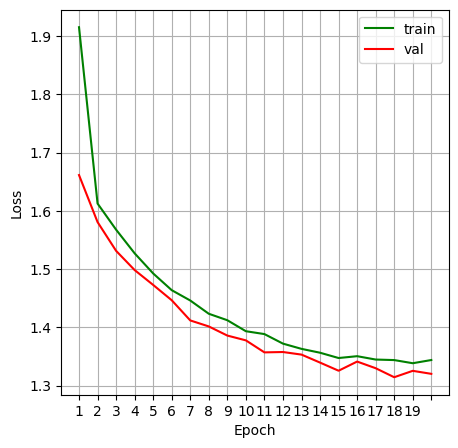

In [48]:
get_losses_plot(history, NUM_EPOCHS)

C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_23076\3979432584.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([i for i in range(NUM_EPOCHS)])
C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_23076\3979432584.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([i for i in range(NUM_EPOCHS)])
C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_23076\3979432584.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  return fig.show()


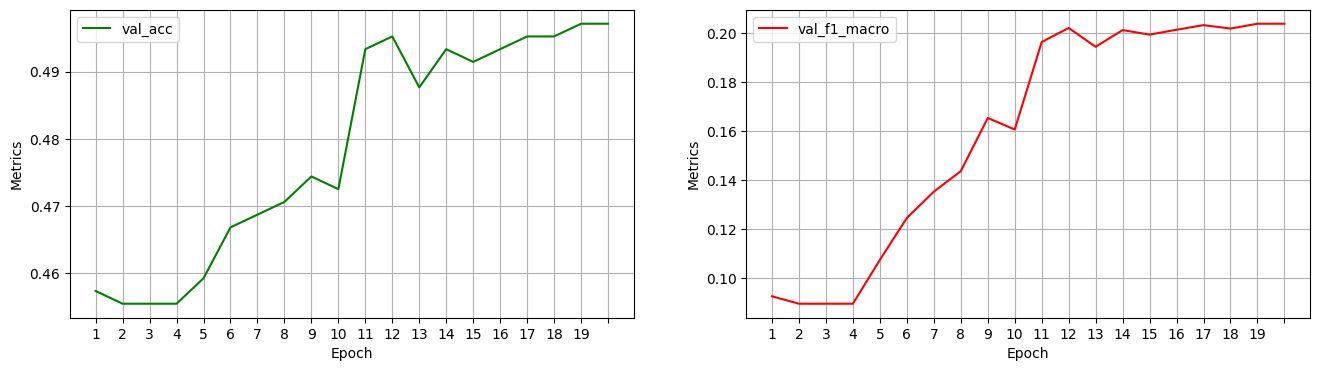

In [47]:
get_metrics_plot(history, NUM_EPOCHS)

              precision    recall  f1-score   support

           0     0.3415    0.1443    0.2029        97
           1     0.0000    0.0000    0.0000        39
           2     0.8750    0.3500    0.5000        40
           3     0.0000    0.0000    0.0000        50
           4     0.0000    0.0000    0.0000        26
           5     0.4947    0.9667    0.6544       240
           6     1.0000    0.0286    0.0556        35

    accuracy                         0.4953       527
   macro avg     0.3873    0.2128    0.2018       527
weighted avg     0.4210    0.4953    0.3770       527



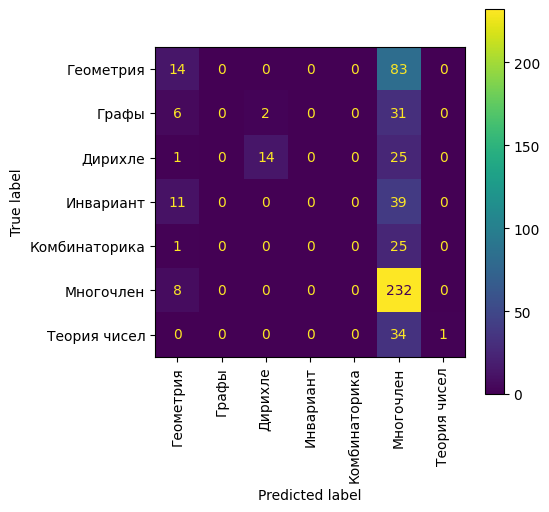

In [49]:
print(classification_report(y_true, y_pred, digits=4, zero_division=0))
cm = confusion_matrix(y_true, y_pred)
plt.rcParams["figure.figsize"] = (5,5) 
disp = ConfusionMatrixDisplay(cm, display_labels = ru_mapping.keys())
disp.plot(xticks_rotation='vertical')

In [50]:
MODEL_NAME = 'tbs17/MathBert'
mathbert_tiny_transformer_model = TrainerClassificationModel(MODEL_NAME, device, len(en_mapping)).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tbs17/MathBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
history, model, y_true, y_pred = train_model(
    mathbert_tiny_transformer_model,
    NUM_EPOCHS,
    en_train_loader,
    en_test_loader,
    'en_full',
    freeze_backbone=False,
)

trainable params: 109487623 / 109487623
epoch 1 // 20


100%|██████████| 149/149 [00:58<00:00,  2.54it/s]


train_loss = 1.3073457475476618
val_loss = 1.0541229914216435
epoch 2 // 20


100%|██████████| 149/149 [01:09<00:00,  2.13it/s]


train_loss = 0.9810189664763892
val_loss = 0.9549415567341972
epoch 3 // 20


100%|██████████| 149/149 [00:58<00:00,  2.53it/s]


train_loss = 0.8291600530579586
val_loss = 0.9567610130590551
epoch 4 // 20


100%|██████████| 149/149 [01:00<00:00,  2.48it/s]


train_loss = 0.699733596920167
val_loss = 1.056654723251567
epoch 5 // 20


100%|██████████| 149/149 [00:59<00:00,  2.52it/s]


train_loss = 0.5704240626936791
val_loss = 1.127833317307865
epoch 6 // 20


100%|██████████| 149/149 [00:58<00:00,  2.54it/s]


train_loss = 0.506132575289515
val_loss = 1.2063088487176334
epoch 7 // 20


100%|██████████| 149/149 [00:58<00:00,  2.54it/s]


train_loss = 0.4339290477285449
val_loss = 1.29985291817609
epoch 8 // 20


 28%|██▊       | 41/149 [00:16<00:42,  2.52it/s]


KeyboardInterrupt: 

C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_23076\3979432584.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([i for i in range(num_epoch)])


<Axes: xlabel='Epoch', ylabel='Loss'>

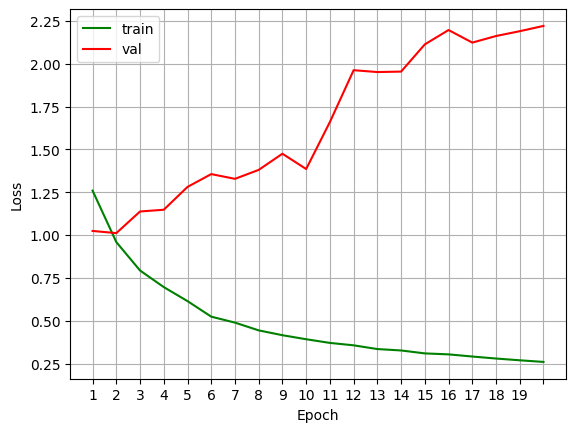

In [34]:
get_losses_plot(history, NUM_EPOCHS)

C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_23076\3979432584.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([i for i in range(NUM_EPOCHS)])
C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_23076\3979432584.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([i for i in range(NUM_EPOCHS)])
C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_23076\3979432584.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  return fig.show()


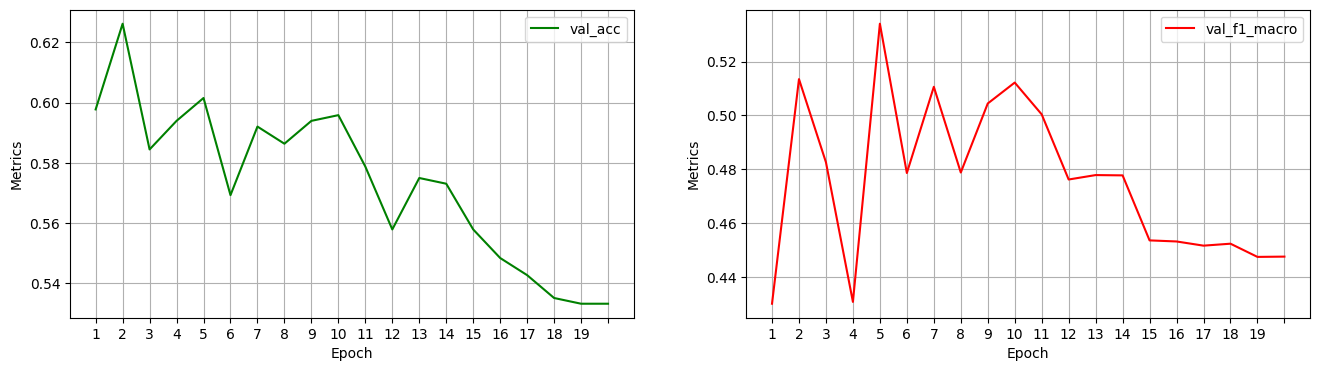

In [35]:
get_metrics_plot(history, NUM_EPOCHS)

              precision    recall  f1-score   support

           0     0.4080    0.7320    0.5240        97
           1     0.3846    0.1282    0.1923        39
           2     0.9714    0.8500    0.9067        40
           3     0.2500    0.0200    0.0370        50
           4     0.4444    0.6154    0.5161        26
           5     0.7982    0.7417    0.7689       240
           6     0.5952    0.7143    0.6494        35

    accuracy                         0.6262       527
   macro avg     0.5503    0.5431    0.5135       527
weighted avg     0.6260    0.6262    0.6018       527



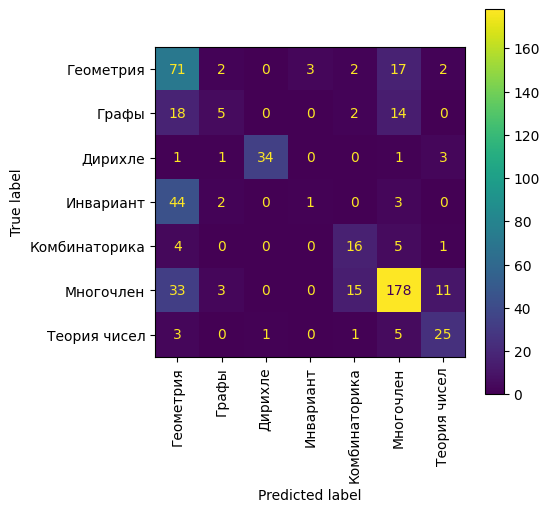

In [36]:
print(classification_report(y_true, y_pred, digits=4, zero_division=0))
cm = confusion_matrix(y_true, y_pred)
plt.rcParams["figure.figsize"] = (5,5) 
disp = ConfusionMatrixDisplay(cm, display_labels = ru_mapping.keys())
disp.plot(xticks_rotation='vertical')

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [62]:
def get_attention_fig(text: str, attention_layer, model: AttentionModel, mapping, n_heads = 4, n_rows = 2, n_cols = 2):
    assert n_rows * n_cols == n_heads

    fig = plt.figure(figsize=(12 * n_cols, 12 * n_rows))

    enc = model.tokenizer(text, return_tensors="pt", truncation=True).to(model.device)
    ticks = model.tokenizer.convert_ids_to_tokens(enc["input_ids"][0])

    with torch.no_grad():
        out = model(**enc)
    attns  = out["attentions"]    
    att_first = attns[attention_layer][0]  
    logits = out["logits"]   

    print(f"Predicted class: {list(mapping.keys())[np.argmax(logits.cpu(), axis=-1)]}")

    L = att_first.shape[-1]
    assert L == len(ticks), f"len(tokens)={len(ticks)} != L={L}"  

    for i in range(n_heads):

        ax = fig.add_subplot(n_rows, n_cols, i+1)

        _attention = att_first[i].cpu().detach().numpy()
        cax = ax.matshow(_attention, cmap='magma')

        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.grid(False)

        ax.set_title(f'Head {i+1}', size=22)
        ax.set_xlabel("key", size=19)
        ax.set_ylabel("query", size=19)
        ax.tick_params(labelsize=15)

        # позиции тиков
        positions = np.arange(L)
        ax.set_xticks(positions)
        ax.set_yticks(positions)

        # подписи
        ax.set_xticklabels(ticks,
                           rotation=90
                           )
        ax.set_yticklabels(ticks)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        ax.xaxis.set_ticks_position('bottom')
        ax.xaxis.set_label_position('bottom')

        fig.tight_layout()

    return fig.show()

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

Predicted class: Графы


C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_23076\2519512542.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  return fig.show()


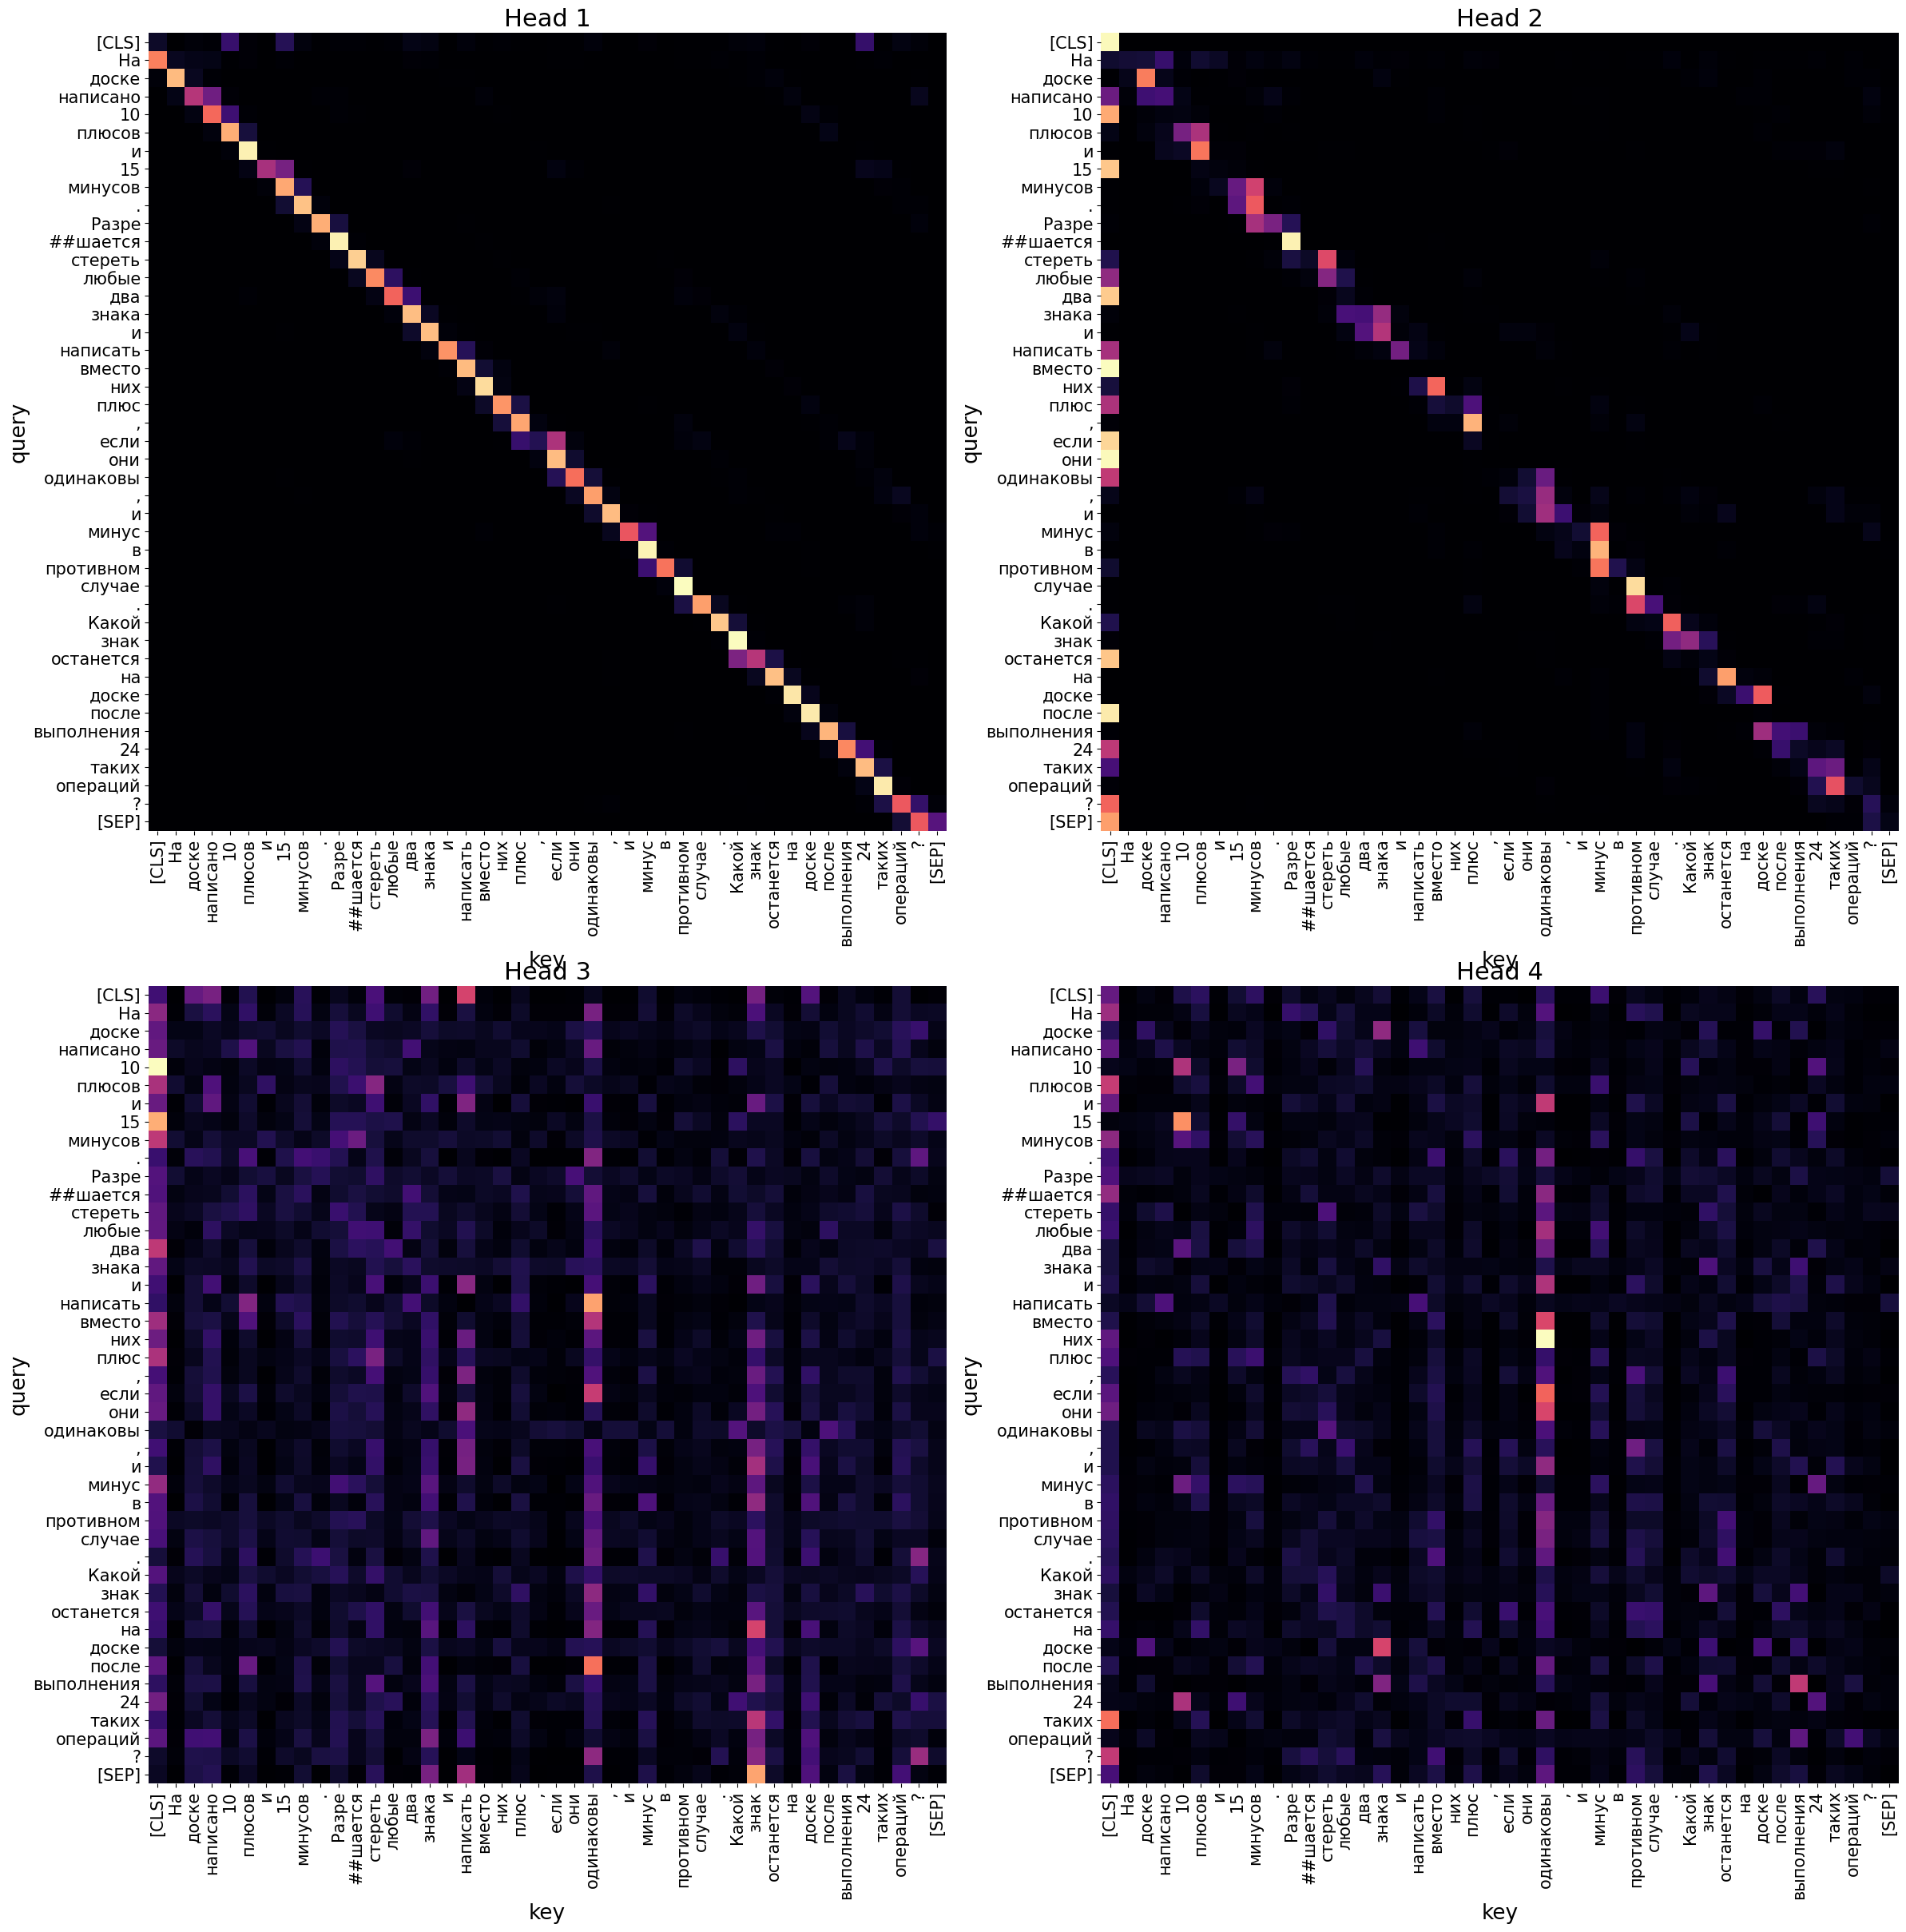

In [ ]:
# insp = AttentionModel('cointegrated/rubert-tiny2', device, len(ru_mapping)).to(device).eval()
# text = 'Геометрия - это раздел математики, изучающий свойства и отношения точек, линий, поверхностей и фигур в пространстве.'
text = ru_X_test.to_list()[1]
get_attention_fig(text, attention_layer=0, model=insp, mapping=ru_mapping, n_heads=4, n_rows=2, n_cols=2)

Head 1.
Почти идеальная диагональ, каждая позиция фокусируется на себе.
Такая голова помогает модели запомнить позиционную и токеновую информацию.

Head 2.
Диагональ чуть «размыта»: видно, что внимание немного смещается на соседние токены.
Это отражает локальные зависимости — например, между словами «любые два знака» или «какой знак».
Голова 2 начинает формировать короткие синтаксические связи.
Также в этой и последующих головах идет внимание на CLS токен, который агрегирует глобальный смысл предложения для аздачи классификации.

Head 3
Диагональ почти исчезает, а активность сосредоточена в отдельных вертикальных столбцах.
Это означает, что некоторые токены (например, «знак», «одинаковы») служат глобальными контекстными якорями, к которым обращаются многие другие слова.
Такие головы часто отвечают за понимание логической структуры: условия, операции, повторяющиеся конструкции.

Head 4
Ещё более рассеянный паттерн, с выраженными «светлыми» столбцами.
Здесь внимание концентрируется на отдельных служебных или числовых токенах, что указывает на семантическое обобщение: голова ищет ключевые элементы выражений (например, числа 10 и 15).

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tbs17/MathBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Predicted class: dirichlet


C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_23076\1622587664.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  return fig.show()


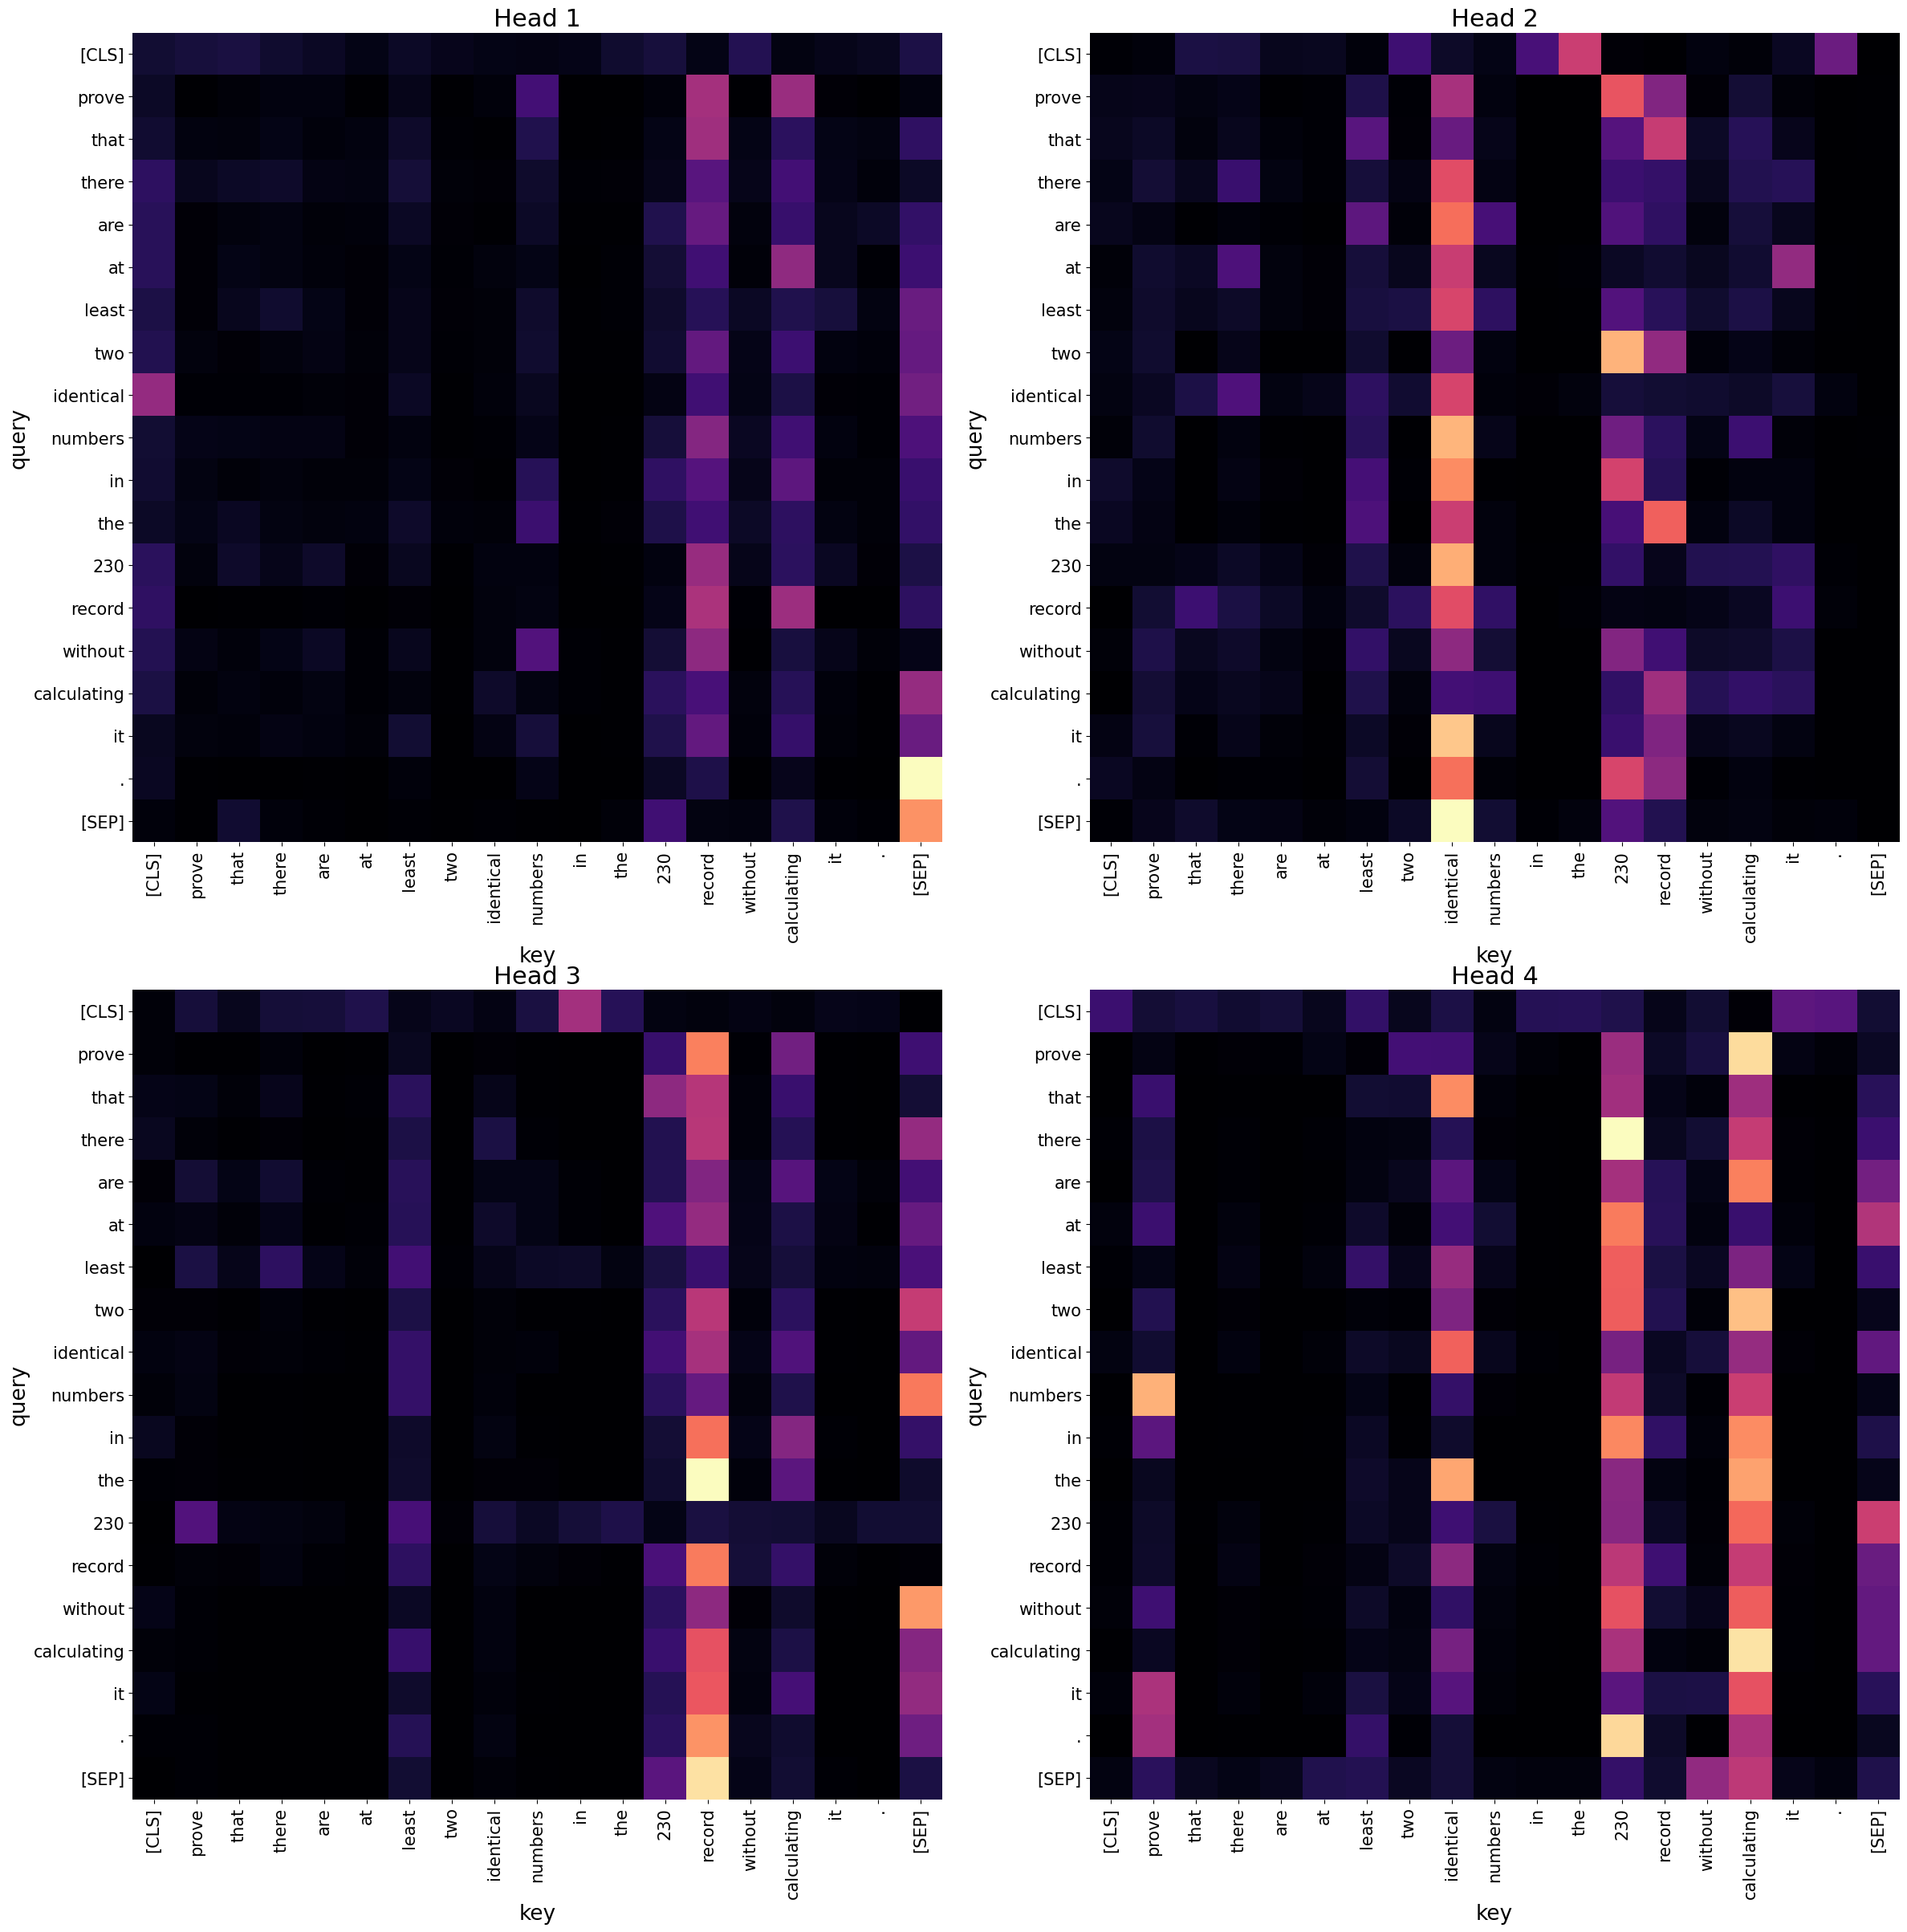

In [79]:
insp = AttentionModel('tbs17/MathBert', device, len(ru_mapping)).to(device).eval()
text = en_X_test.to_list()[30]
get_attention_fig(text, attention_layer=0, model=insp, mapping=en_mapping, n_heads=4, n_rows=2, n_cols=2)

Если честно, непонятно, почему у первых голов нет self-attention диагонали, где каждая позиция фокусируется на себе.
Возможно, это особенности этого дообученного BERT-классификатора.

Head 1.
Внимание сосредоточено на [SEP] и словах “record”, “calculating”.
Это типичная head конца предложения, которая агрегирует информацию в финальные токены, помогая свернуть смысл перед [SEP].

Head 2.
Сильное внимание между “prove” → “that” и “identical” → “numbers”.
Такая структура отражает синтаксико-семантические зависимости: головные слова обращаются к зависимым.

Head 3.
Активность на “230” и “record” показывает, что эта голова реагирует на числовые и предметные сущности.

Head 4.
Чёткие вертикальные столбцы для “identical”, “numbers”, “record”.
Это голова, строящая связи между сущностями и их атрибутами.

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted class: Инвариант


C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_23076\1622587664.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  return fig.show()


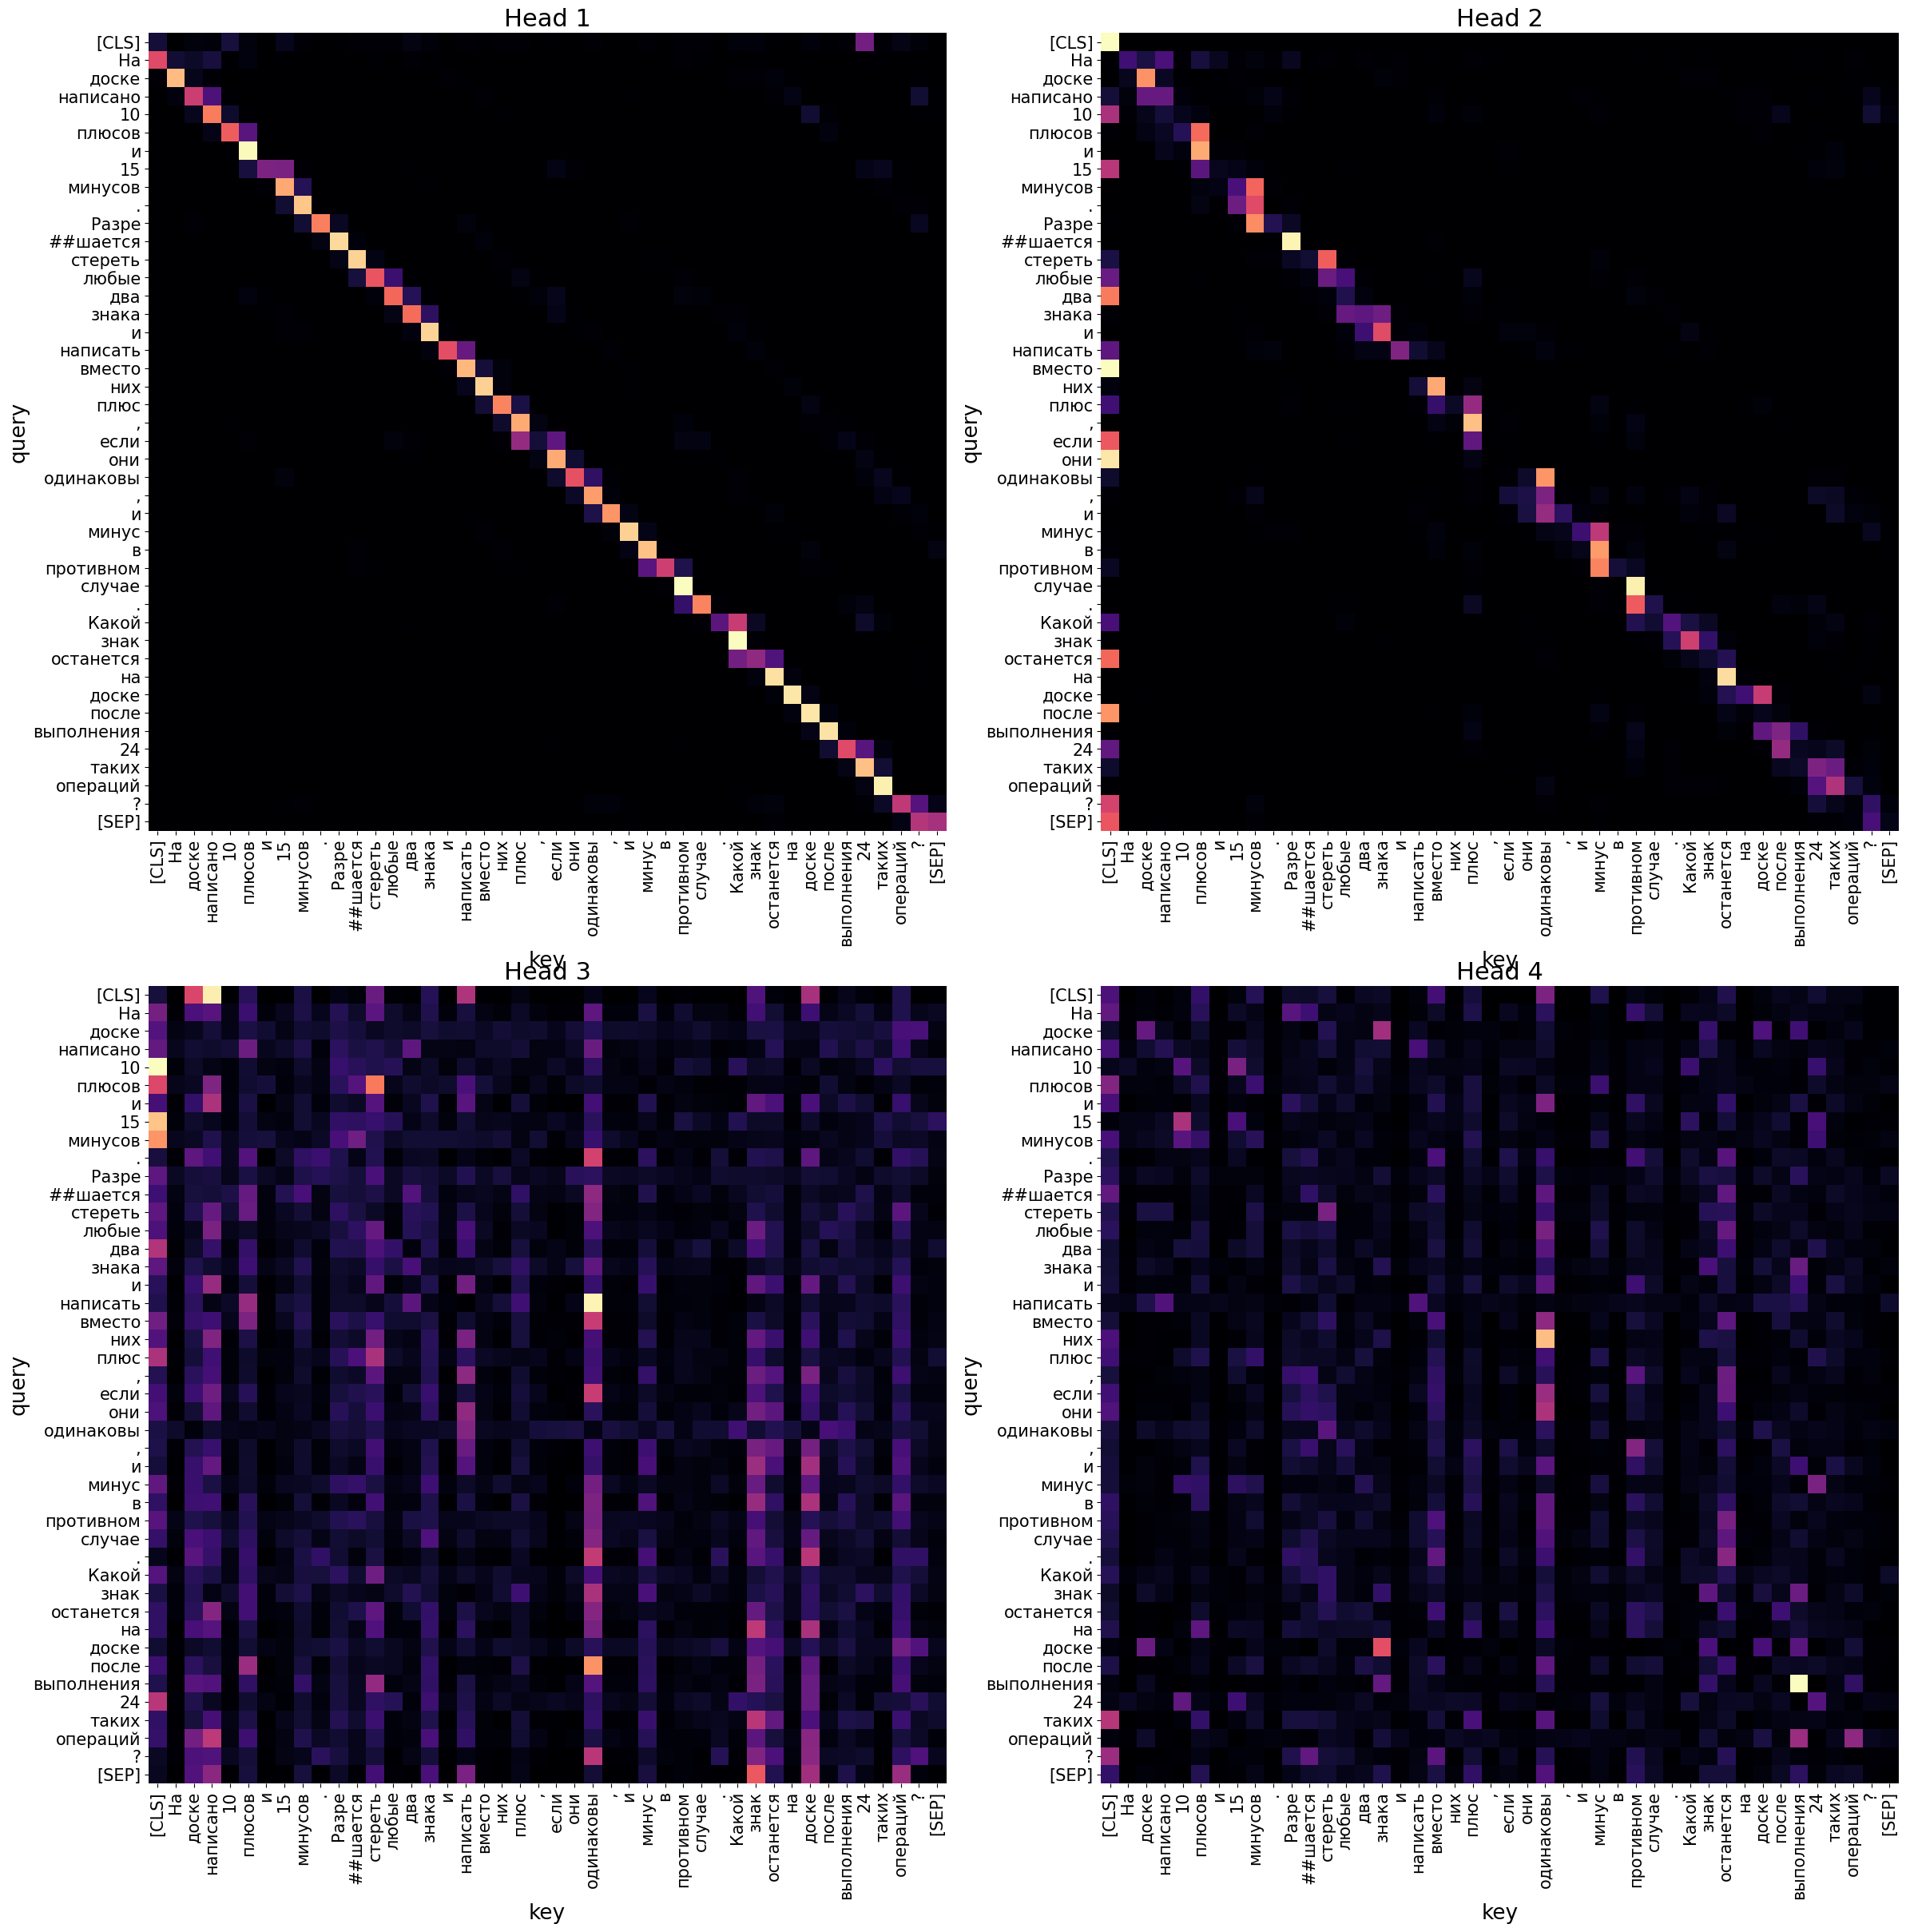

In [67]:
# загрузка
insp = AttentionModel('cointegrated/rubert-tiny2', device, len(ru_mapping)).to(device).eval()
insp.load_state_dict(torch.load("models/ru_full.pth", map_location=insp.device), strict=True)
text = ru_X_test.to_list()[1]
get_attention_fig(text, attention_layer=0, model=insp, mapping=ru_mapping, n_heads=4, n_rows=2, n_cols=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tbs17/MathBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Predicted class: dirichlet


C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_23076\1622587664.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  return fig.show()


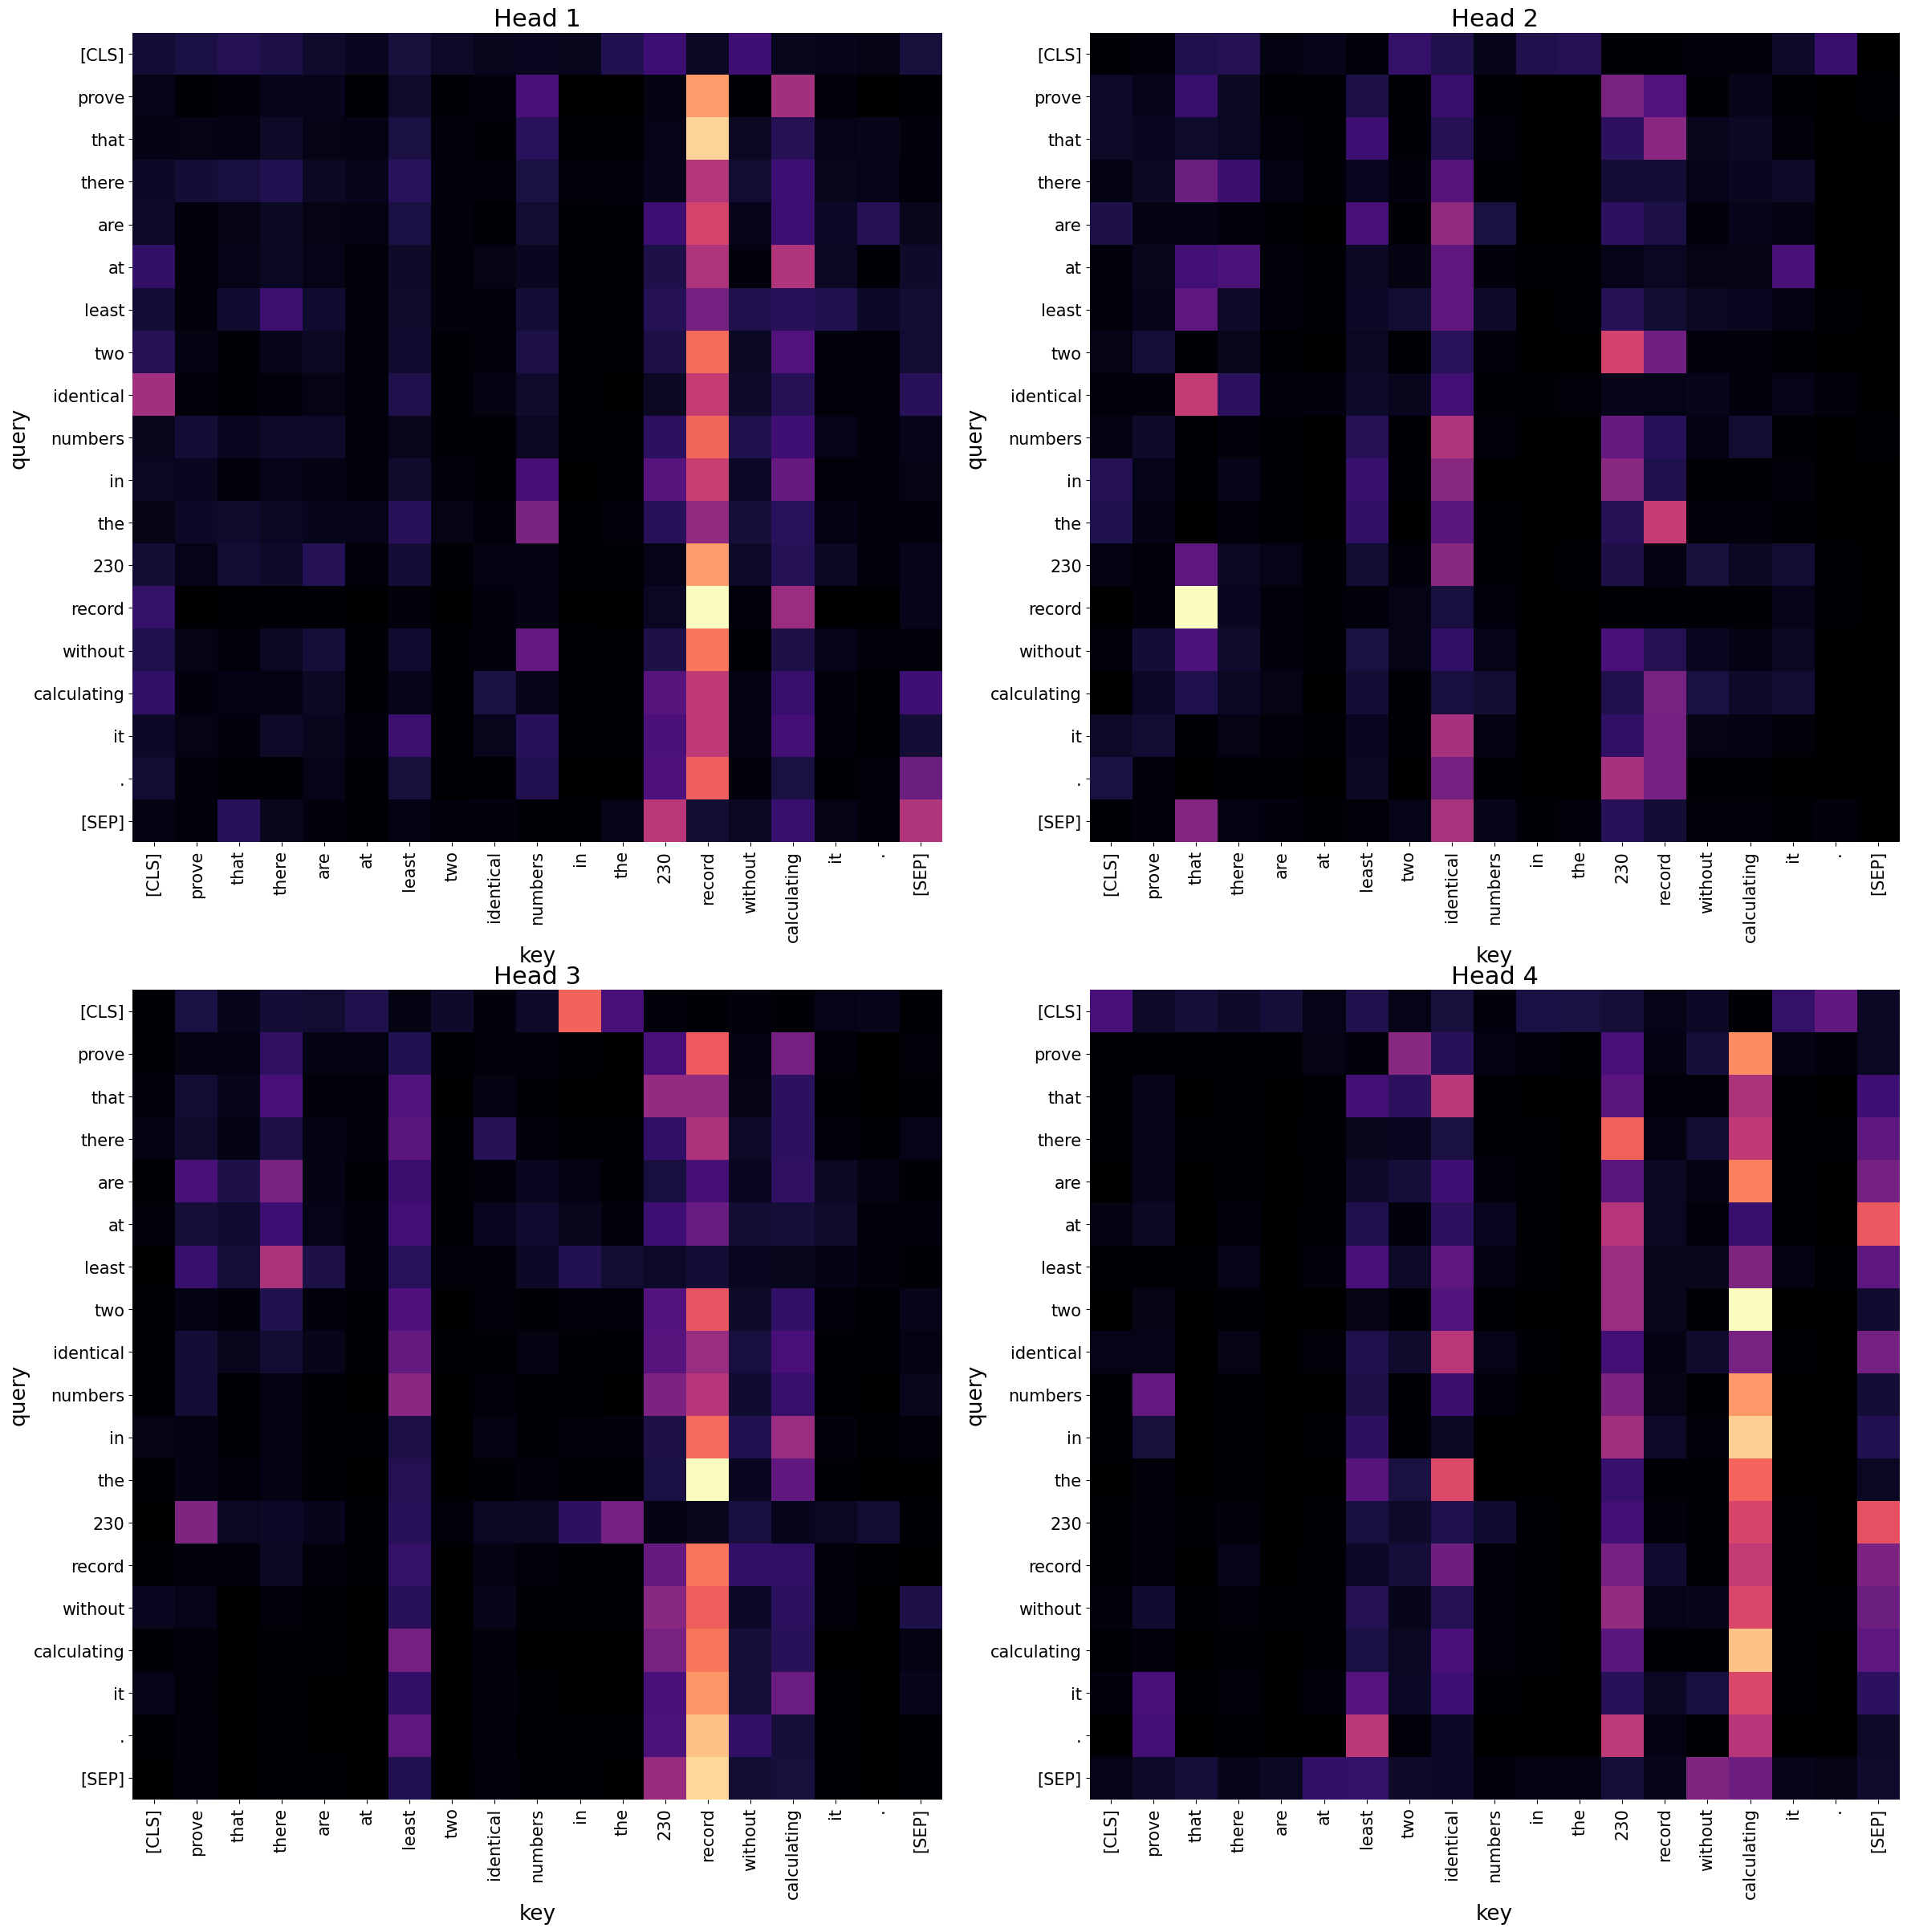

In [75]:
# загрузка
insp = AttentionModel('tbs17/MathBert', device, len(ru_mapping)).to(device).eval()
insp.load_state_dict(torch.load("models/en_full.pth", map_location=insp.device), strict=True)
text = en_X_test.to_list()[30]
get_attention_fig(text, attention_layer=0, model=insp, mapping=en_mapping, n_heads=4, n_rows=2, n_cols=2)

Головы внимания до и после обучения почти не меняются, очень слабо.

После дообучения ruBERT появляются яркие узлы внимания: вероятно, головы начинают лучше улавливать семантические связи и операционные зависимости между словами, а не только локальные токен-токен корреляции.

У предобученной MathBERT внимание распределено хаотично: головы фокусируются на общих токенах (например, [SEP]) без чёткой семантики. После fine-tuning все тот же хаос, но некоторые узлы внимания становятся ярче (least), какие-то тусклее (SEP). Это говорит о том, что головы начинают пытаться выделять некие математические концепты и переходить от поверхностной языковой обработки к пониманию структур доказательств и связей между элементами задачи.